In [2]:
from fastai.vision import *
from fastai.vision.all import *
import pandas as pd
import numpy as np
from PIL import Image
import os

In [5]:
df = pd.read_csv('updated_2018_detections')

In [6]:
train = df[df['Location'] == 'CHIL - R']

In [7]:
def get_data(sz, bs):
    """
      Function to iterate a new dataloader with progressive
        image resizing

      sz = Image size 
      bs = Batch size
      """
    tfms = [Resize(sz, method='pad'),
            Normalize.from_stats(*imagenet_stats),
            *aug_transforms(do_flip=False, size=sz)]
  
    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),      
        getters=[ColReader('Directory', pref='images/'),   # image input
                 ColReader('ShortName')],
        splitter=TrainTestSplitter(test_size=.2, random_state=42, stratify=train['ShortName']),
        batch_tfms=tfms
    )
    
    dls = dblock.dataloaders(train, bs=bs)
    dls = dls.cuda()
    return dls

In [8]:
def img_resize_training(sizes):
    for i, im_size in enumerate(sizes):
        # scale down batch size as im_size increases
        bs = int(2048 / im_size)
        dls = get_data(im_size, bs)
    
        # Train fresh model at start then progressively load weights
        if i == 0:
            learn = cnn_learner(dls, models.resnet50, metrics=[error_rate, accuracy])
            learn.model = learn.model.cuda()
      
        else:
            learn = cnn_learner(dls, models.resnet50, metrics=[error_rate, accuracy])
            learn.load('res50_' + str(sizes[i-1]))
            learn.model = learn.model.cuda()
      
        # train final class layers
        learn.fit_one_cycle(6*(i+1))

        ## i + to 1
        # unfreeze and train whole network
        learn.fine_tune(2*(i+1))

        # save model 
        learn.save('res50_'+ str(sizes[i]))
        
    return learn

In [ ]:
sizes = [64, 128, 256, 512]
learn = img_resize_training(sizes)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
dls = get_data(256, 32)
learn = cnn_learner(dls, models.resnet50, metrics=[error_rate, accuracy]).load('res50_512')

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-4)

In [ ]:
learn.fine_tune(5)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.print_classification_report()

               precision    recall  f1-score   support

         bird       0.79      0.51      0.62       171
          cat       0.36      0.27      0.31        15
       coyote       0.83      0.72      0.77        61
          dog       0.61      0.54      0.58        35
e. cottontail       0.81      0.70      0.75       134
        empty       0.92      0.97      0.94      3287
        human       0.91      0.88      0.89       295
   lawn mower       1.00      0.25      0.40         8
      raccoon       0.89      0.93      0.91       347
          rat       0.00      0.00      0.00         8
     squirrel       0.81      0.66      0.73       386
striped skunk       0.92      0.86      0.89        14
   v. opossum       0.74      0.63      0.68        59
   w. t. deer       0.89      0.82      0.86       112

     accuracy                           0.90      4932
    macro avg       0.75      0.62      0.67      4932
 weighted avg       0.89      0.90      0.89      4932



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


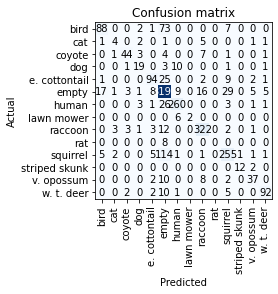

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()
# actual, predicted

[('squirrel', 'empty', 114),
 ('bird', 'empty', 73),
 ('empty', 'squirrel', 29),
 ('human', 'empty', 26),
 ('e. cottontail', 'empty', 25),
 ('empty', 'bird', 17),
 ('empty', 'raccoon', 16),
 ('raccoon', 'empty', 12),
 ('dog', 'human', 10),
 ('v. opossum', 'empty', 10),
 ('w. t. deer', 'empty', 10),
 ('e. cottontail', 'squirrel', 9),
 ('empty', 'human', 9),
 ('empty', 'e. cottontail', 8),
 ('rat', 'empty', 8),
 ('v. opossum', 'raccoon', 8),
 ('bird', 'squirrel', 7),
 ('coyote', 'raccoon', 7),
 ('lawn mower', 'human', 6),
 ('cat', 'raccoon', 5),
 ('empty', 'v. opossum', 5),
 ('empty', 'w. t. deer', 5),
 ('squirrel', 'bird', 5),
 ('squirrel', 'e. cottontail', 5),
 ('w. t. deer', 'squirrel', 5),
 ('coyote', 'empty', 4),
 ('coyote', 'dog', 3),
 ('dog', 'empty', 3),
 ('empty', 'coyote', 3),
 ('human', 'dog', 3),
 ('human', 'squirrel', 3),
 ('raccoon', 'cat', 3),
 ('raccoon', 'coyote', 3),
 ('raccoon', 'e. cottontail', 3),
 ('bird', 'dog', 2),
 ('cat', 'dog', 2),
 ('e. cottontail', 'raccoon',